# Implementing a Recommender System with SageMaker, MXNet, and Gluon
## _**Making Product - Shoes Recommendations Using Neural Networks and Embeddings**_

--- 


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Explore](#Explore)
  1. [Clean](#Clean)
  1. [Prepare](#Prepare)
1. [Train Locally](#Train-Locally)
  1. [Define Network](#Define-Network)
  1. [Set Parameters](#Set-Parameters)
  1. [Execute](#Execute)
1. [Train with SageMaker](#Train-with-SageMaker)
  1. [Wrap Code](#Wrap-Code)
  1. [Move Data](#Move-Data)
  1. [Submit](#Submit)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Wrap-up](#Wrap-up)

---

## Background

#### In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

#### Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.  The minimal required dataset for this is a history of user item ratings.  In our case, we'll use 1 to 5 star ratings from over 2M Amazon customers.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

#### Matrix factorization has been the cornerstone of most user-item prediction models.  This method starts with the large, sparse, user-item ratings in a single matrix, where users index the rows, and items index the columns.  It then seeks to find two lower-dimensional, dense matrices which, when multiplied together, preserve the information and relationships in the larger matrix.

![image](./images/1_PefuBiYr9Bp7lo_zotGj0Q.png)

### ** Matrix factorization has been extended and genarlized with deep learning and embeddings.  These techniques allows us to introduce non-linearities for enhanced performance and flexibility.  This notebook will fit a neural network-based model to generate recommendations for the Amazon dataset.  It will start by exploring our data in the notebook and even training a model on a sample of the data.  Later we'll expand to the full dataset and fit our model using a SageMaker managed training cluster.  We'll then deploy to an endpoint and check our method.

---

## Setup

#### _This notebook was created and tested on an ml.p2.xlarge notebook instance._

#### Let's start by specifying:

#### - The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
#### - The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [1]:
!pip install ipython-autotime

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#### To measure all running time
# https://github.com/cpcloud/ipython-autotime

%load_ext autotime

In [3]:
bucket = 'dse-cohort5-group1'
prefix = 'sagemaker/amazon_reviews_us_Shoes_v1_00'

import sagemaker
role = sagemaker.get_execution_role()

time: 908 ms


Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [177]:
# Install a scikit-image package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-image==0.14.2 

    100% |████████████████████████████████| 25.3MB 1.8MB/s eta 0:00:01
    100% |████████████████████████████████| 808kB 34.6MB/s ta 0:00:01
  Found existing installation: dask 0.17.5
    Uninstalling dask-0.17.5:
      Successfully uninstalled dask-0.17.5
  Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
time: 4.82 s


In [179]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np

import sagemaker
from sagemaker.mxnet import MXNet
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import random_tuner as rt

import boto3
import json
import matplotlib.pyplot as plt

time: 4.23 ms


In [114]:
# for basic visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for advanced visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

time: 3.63 ms


---
## Data - https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

### Explore

Let's start by bringing in our dataset from an S3 public bucket.  As mentioned above, this contains 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

_Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes.  Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage)._

In [5]:
!rm -rf /tmp/recsys/

time: 119 ms


In [6]:
!aws s3 ls s3://amazon-reviews-pds/tsv/

2017-11-24 13:22:50          0 
2017-11-24 13:48:03  241896005 amazon_reviews_multilingual_DE_v1_00.tsv.gz
2017-11-24 13:48:17   70583516 amazon_reviews_multilingual_FR_v1_00.tsv.gz
2017-11-24 13:48:34   94688992 amazon_reviews_multilingual_JP_v1_00.tsv.gz
2017-11-24 13:49:14  349370868 amazon_reviews_multilingual_UK_v1_00.tsv.gz
2017-11-24 13:48:47 1466965039 amazon_reviews_multilingual_US_v1_00.tsv.gz
2017-11-24 13:49:53  648641286 amazon_reviews_us_Apparel_v1_00.tsv.gz
2017-11-24 13:56:36  582145299 amazon_reviews_us_Automotive_v1_00.tsv.gz
2017-11-24 14:04:02  357392893 amazon_reviews_us_Baby_v1_00.tsv.gz
2017-11-24 14:08:11  914070021 amazon_reviews_us_Beauty_v1_00.tsv.gz
2017-11-24 14:17:41 2740337188 amazon_reviews_us_Books_v1_00.tsv.gz
2017-11-24 14:45:50 2692708591 amazon_reviews_us_Books_v1_01.tsv.gz
2017-11-24 15:10:21 1329539135 amazon_reviews_us_Books_v1_02.tsv.gz
2017-11-24 15:22:13  442653086 amazon_reviews_us_Camera_v1_00.tsv.gz
2017-11-24 15:27:13 2689739299 amazon_rev

In [7]:
!rm -rf  /tmp/recsys/
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz /tmp/recsys/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz to ../../../../../../tmp/recsys/amazon_reviews_us_Shoes_v1_00.tsv.gz
time: 4.91 s


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [8]:
!ls -alh /tmp/recsys/

total 613M
drwxrwxr-x  2 ec2-user ec2-user 4.0K May 16 15:10 .
drwxrwxrwx 33 root     root     148K May 16 15:10 ..
-rw-rw-r--  1 ec2-user ec2-user 613M Nov 25  2017 amazon_reviews_us_Shoes_v1_00.tsv.gz
time: 121 ms


In [156]:
df = pd.read_csv('/tmp/recsys/amazon_reviews_us_Shoes_v1_00.tsv.gz', delimiter='\t', error_bad_lines=False)

b'Skipping line 54101: expected 15 fields, saw 22\nSkipping line 55857: expected 15 fields, saw 22\nSkipping line 60448: expected 15 fields, saw 22\n'
b'Skipping line 76918: expected 15 fields, saw 22\nSkipping line 87925: expected 15 fields, saw 22\nSkipping line 88500: expected 15 fields, saw 22\nSkipping line 114276: expected 15 fields, saw 22\nSkipping line 128751: expected 15 fields, saw 22\n'
b'Skipping line 136095: expected 15 fields, saw 22\nSkipping line 140007: expected 15 fields, saw 22\nSkipping line 177148: expected 15 fields, saw 22\nSkipping line 180087: expected 15 fields, saw 22\nSkipping line 183010: expected 15 fields, saw 22\nSkipping line 183949: expected 15 fields, saw 22\nSkipping line 192879: expected 15 fields, saw 22\n'
b'Skipping line 223261: expected 15 fields, saw 22\nSkipping line 240588: expected 15 fields, saw 22\nSkipping line 247955: expected 15 fields, saw 22\nSkipping line 249336: expected 15 fields, saw 22\nSkipping line 259363: expected 15 fields, 

time: 39.4 s


# ** Amazon product dataset data analysis 

We can see this dataset includes information like:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case this products).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

For this example, let's limit ourselves to `customer_id`, `product_id`, and `star_rating`.  Including additional features in our recommendation system could be beneficial, but would require substantial processing (particularly the text data) which would take us beyond the scope of this notebook.

*Note: we'll keep `product_title` on the dataset to help verify our recommendations later in the notebook, but it will not be used in algorithm training.*

Because most people haven't seen most videos, and people rate fewer videos than we actually watch, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [157]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,US,108364,R2NZXYIVCGB13W,B00XFBPOQG,448483263,adidas Men's 10K Lifestyle Runner Sneaker,Shoes,5,0,6,N,Y,Badass,Getting what u see,2015-08-31
4,US,45449350,R2EQ1TG9IT3OEQ,B00SW64Y9W,7853171,OverBling Sneakers for Men Casual Men Shoes Ge...,Shoes,3,0,0,N,Y,Three Stars,small,2015-08-31


time: 16.4 ms


In [158]:
# shape of data
df.shape

(4358820, 15)

time: 2.32 ms


In [159]:
# Describing the data set
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,4.358820e+06,4.358820e+06,4.358820e+06,4.358820e+06,4.358820e+06
mean,2.631178e+07,4.983149e+08,4.241249e+00,8.777460e-01,1.076503e+00
std,1.546916e+07,2.898457e+08,1.157505e+00,7.563358e+00,8.137539e+00
min,1.001700e+04,2.220000e+02,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.338500e+07,2.463836e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.445766e+07,4.976083e+08,5.000000e+00,0.000000e+00,0.000000e+00
75%,4.090312e+07,7.502587e+08,5.000000e+00,1.000000e+00,1.000000e+00
max,5.309657e+07,9.999999e+08,5.000000e+00,5.070000e+03,5.329000e+03


time: 1.27 s


In [160]:
# checking if there is any null data or not
df.isnull().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          1
product_category       0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline       26
review_body          440
review_date           21
dtype: int64

time: 3.03 s


In [161]:
# remove numm data
df = df.dropna()

time: 4.03 s


In [162]:
df.head(n=3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31


time: 15.3 ms


In [163]:
# checking if there is any null data or not
df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

time: 3.03 s


In [164]:
# Describing the data according to the ratings
df.groupby('star_rating').describe()

customer_id                                                    \
                  count          mean           std      min          25%   
star_rating                                                                 
1              231702.0  2.613264e+07  1.555256e+07  10216.0  13159540.00   
2              242368.0  2.728759e+07  1.524881e+07  10121.0  14220759.25   
3              403414.0  2.675237e+07  1.538036e+07  10017.0  13773124.75   
4              846151.0  2.642434e+07  1.545640e+07  10053.0  13493269.00   
5             2634698.0  2.613613e+07  1.549374e+07  10022.0  13235135.50   

                                                 product_parent                \
                    50%          75%         max          count          mean   
star_rating                                                                     
1            24184169.5  40816197.00  53096405.0       231702.0  4.972857e+08   
2            25811489.5  41616422.25  53096567.0       242368.0  4.992033e+08   
3            25079965.5  41269264.50  53096471.0       403414.0  4.976268e+08   
4            24626637.0  41006751.50  53096474.0       846151.0  4.983365e+08   
5            24214413.0  40719567.00  53096567.0      2634698.0  4.984187e+08   

             ... helpful_votes         total_votes                            \
             ...           75%     max       count      mean        std  min   
star_rating  ...                                                               
1            ...           1.0  2293.0    231702.0  2.729437  12.343236  0.0   
2            ...           1.0   769.0    242368.0  1.558164   6.155664  0.0   
3            ...           1.0   494.0    403414.0  1.178992   5.193058  0.0   
4            ...           0.0  1338.0    846151.0  0.896550   4.915773  0.0   
5            ...           0.0  5070.0   2634698.0  0.927385   8.966711  0.0   

                                    
             25%  50%  75%     max  
star_rating                         
1            0.0  1.0  2.0  2522.0  
2            0.0  0.0  1.0   799.0  
3            0.0  0.0  1.0   513.0  
4            0.0  0.0  1.0  1357.0  
5            0.0  0.0  1.0  5329.0  

[5 rows x 32 columns]

time: 3.43 s


In [94]:
df = df[['customer_id', 'product_id', 'star_rating', 'product_title']]

time: 839 ms


In [13]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.00      1.0
0.01      1.0
0.02      1.0
0.03      1.0
0.04      1.0
0.05      1.0
0.10      1.0
0.25      1.0
0.50      1.0
0.75      2.0
0.90      3.0
0.95      4.0
0.96      4.0
0.97      5.0
0.98      6.0
0.99      8.0
1.00    210.0
Name: customer_id, dtype: float64
products
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       4.0
0.95       6.0
0.96       8.0
0.97       9.0
0.98      12.0
0.99      18.0
1.00    1247.0
Name: product_id, dtype: float64
time: 4.3 s


As we can see, only about 5% of customers have rated 5 or more videos, and only 25% of videos have been rated by 9+ customers.

### Clean

Let's filter out this long tail.

In [14]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

time: 4 s


Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [15]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

time: 80.9 ms


Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [16]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,star_rating,product_title,user,item
0,20381037,B008KK1D5S,4,Clarks Women's Breeze Sea Flip-Flop,27011,8651
1,19765964,B008KK1D5S,4,Clarks Women's Breeze Sea Flip-Flop,37672,8651
2,45857594,B008KK1D5S,4,Clarks Women's Breeze Sea Flip-Flop,36278,8651
3,29765060,B008KK1D5S,5,Clarks Women's Breeze Sea Flip-Flop,24721,8651
4,20381037,B0068UU4H0,4,zeroUV - Womens Oversized Large Bold Square Fa...,27011,164


time: 183 ms


### Prepare

Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training.

In [17]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

time: 1.84 s


Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator.  This process is the same for both test and control.

In [18]:
batch_size = 1024

train = gluon.data.ArrayDataset(nd.array(train_df['user'].values, dtype=np.float32),
                                nd.array(train_df['item'].values, dtype=np.float32),
                                nd.array(train_df['star_rating'].values, dtype=np.float32))
test  = gluon.data.ArrayDataset(nd.array(test_df['user'].values, dtype=np.float32),
                                nd.array(test_df['item'].values, dtype=np.float32),
                                nd.array(test_df['star_rating'].values, dtype=np.float32))

train_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')
test_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')

time: 349 ms


---

## Train Locally

### Define Network

Let's start by defining the neural network version of our matrix factorization task.  In this case, our network is quite simple.  The main components are:
- [Embeddings](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Embedding) which turn our indexes into dense vectors of fixed size.  In this case, 64.
- [Dense layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dense) with ReLU activation.  Each dense layer has the same number of units as our number of embeddings.  Our ReLU activation here also adds some non-linearity to our matrix factorization.
- [Dropout layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dropout) which can be used to prevent over-fitting.
- Matrix multiplication of our user matrix and our item matrix to create an estimate of our rating matrix.

In [19]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            
            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)

            self.dense_user   = gluon.nn.Dense(num_emb, activation='relu')
            self.dense_item = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)
        
        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)     
        predictions = F.sum(predictions, axis=1)
        return predictions

time: 6.82 ms


In [20]:
num_embeddings = 64

net = MFBlock(max_users=customer_index.shape[0], 
              max_items=product_index.shape[0],
              num_emb=num_embeddings,
              dropout_p=0.5)


time: 3.06 ms


### Set Parameters

Let's initialize network weights and set our optimization parameters.

In [21]:
# Initialize network parameters
ctx = mx.gpu()
net.collect_params().initialize(mx.init.Xavier(magnitude=60),
                                ctx=ctx,
                                force_reinit=True)
net.hybridize()

# Set optimization parameters
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

time: 52.8 s


### Execute

Let's define a function to carry out the training of our neural network.

In [22]:
def execute(train_iter, test_iter, net, epochs, ctx):
    
    loss_function = gluon.loss.L2Loss()
    for e in range(epochs):
        
        print("epoch: {}".format(e))
        
        for i, (user, item, label) in enumerate(train_iter):
                user = user.as_in_context(ctx)
                item = item.as_in_context(ctx)
                label = label.as_in_context(ctx)
                
                with mx.autograd.record():
                    output = net(user, item)               
                    loss = loss_function(output, label)
                    
                loss.backward()
                trainer.step(batch_size)

        print("EPOCH {}: MSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_iter, net, ctx, loss_function),
                                                                   eval_net(test_iter, net, ctx, loss_function)))
    print("end of training")
    return net

time: 3.89 ms


Let's also define a function which evaluates our network on a given dataset.  This is called by our `execute` function above to provide mean squared error values on our training and test datasets.

In [23]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):
        
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)
            predictions = net(user, item).reshape((batch_size, 1))
            acc.update(preds=[predictions], labels=[label])
   
    return acc.get()[1]

time: 2.36 ms


Now, let's train for a few epochs.

In [24]:
%%time

epochs = 3

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 1.33128246333864. 1.3310808208253648
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 1.1215184446838167. 1.12072730395529
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 1.1014281511306763. 1.1017890580712932
end of training
CPU times: user 3.89 s, sys: 438 ms, total: 4.33 s
Wall time: 6.07 s
time: 6.07 s


#### Early Validation

We can see our training error going down, but our validation accuracy bounces around a bit.  Let's check how our model is predicting for an individual user.  We could pick randomly, but for this case, let's try user #6.

In [25]:
product_index['u6_predictions'] = trained_net(nd.array([6] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u6_predictions', ascending=False)

,product_id,item,u6_predictions
16781,B005CMHXTC,16781,4.485634
32105,B000G5TTG0,32105,4.483222
37758,B006H1MSTM,37758,4.477142
18382,B007YZBKZ8,18382,4.461633
26580,B000EPA9OS,26580,4.460275
7920,B00847T6K6,7920,4.458715
42247,B001HZBA2E,42247,4.448677
29944,B00E4V1CO4,29944,4.444788
8650,B004LGA1L2,8650,4.424382
6224,B009ZDFTWC,6224,4.423267


time: 150 ms


Now let's compare this to the predictions for another user (we'll try user #7).

In [26]:
product_index['u7_predictions'] = trained_net(nd.array([7] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u7_predictions', ascending=False)

,product_id,item,u6_predictions,u7_predictions
17588,B009NOZ8II,17588,4.229227,4.953543
6683,B008LUJPOS,6683,4.080145,4.913067
28071,B005GIAS3U,28071,4.392945,4.896327
26580,B000EPA9OS,26580,4.460275,4.873698
21339,B001VB732K,21339,4.108026,4.871317
21455,B0019HJBTO,21455,4.219696,4.870849
23782,B0054TNALI,23782,4.257790,4.864652
25947,B00DY616Y6,25947,4.016380,4.849820
30801,B00BG5JTF0,30801,4.027542,4.832591
35546,B0032UYMEU,35546,4.246808,4.827649


time: 42 ms


The predicted ratings are different between the two users, but the same top (and bottom) items for user #6 appear for #7 as well.  Let's look at the correlation across the full set of 38K items to see if this relationship holds.

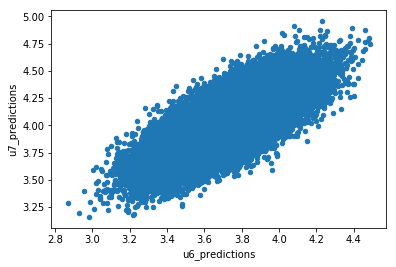

time: 769 ms


In [27]:
product_index[['u6_predictions', 'u7_predictions']].plot.scatter('u6_predictions', 'u7_predictions')
plt.show()

We can see that this correlation is nearly perfect.  Essentially the average rating of items dominates across users and we'll recommend the same well-reviewed items to everyone.  As it turns out, we can add more embeddings and this relationship will go away since we're better able to capture differential preferences across users.

However, with just a 64 dimensional embedding, it took 7 minutes to run just 3 epochs.  If we ran this outside of our Notebook Instance we could run larger jobs and move on to other work would improve productivity.

---

## Train with SageMaker

Now that we've trained on this smaller dataset, we can expand training in SageMaker's distributed, managed training environment.

### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.  There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators), but for our example, it consisted of:
1. Wrapping all data preparation into a `prepare_train_data` function (we could name this whatever we like)
1. Copying and pasting classes and functions from above word-for-word
1. Defining a `train` function that:
  1. Adds a bit of new code to pick up the input TSV dataset on the SageMaker Training cluster
  1. Takes in a dict of hyperparameters (which we specified as globals above)
  1. Creates the net and executes training

In [28]:
!cat recommender.py

import logging
import json
import time
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import numpy as np

os.system('pip install pandas')
import pandas as pd

logging.basicConfig(level=logging.DEBUG)

#########
# Globals
#########

batch_size = 1024


##########
# Training
##########

def train(channel_input_dirs, hyperparameters, hosts, num_gpus, **kwargs):
    
    # get data
    training_dir = channel_input_dirs['train']
    train_iter, test_iter, customer_index, product_index = prepare_train_data(training_dir)
    
    # get hyperparameters
    num_embeddings = hyperparameters.get('num_embeddings', 64)
    opt = hyperparameters.get('opt', 'sgd')
    lr = hyperparameters.get('lr', 0.02)
    momentum = hyperparameters.get('momentum', 0.9)
    wd = hyperparameters.get('wd', 0.)
    epochs = hyperparameters.get('epochs', 5)

    # define net
    ctx = mx.gpu()

    net = MFBlock(max_users=customer_index.shape[0], 
                  max_it

### Test Locally

Now we can test our train function locally.  This helps ensure we don't have any bugs before submitting our code to SageMaker's pre-built MXNet container.

In [29]:
!ls -al /tmp/recsys/

total 627360
drwxrwxr-x  2 ec2-user ec2-user      4096 May 16 15:10 .
drwxrwxrwx 41 root     root        151552 May 16 15:12 ..
-rw-rw-r--  1 ec2-user ec2-user 642255314 Nov 25  2017 amazon_reviews_us_Shoes_v1_00.tsv.gz
time: 237 ms


In [30]:
%%time

import recommender

local_test_net, local_customer_index, local_product_index = recommender.train(
    {'train': '/tmp/recsys/'}, 
    {'num_embeddings': 64, 
     'opt': 'sgd', 
     'lr': 0.02, 
     'momentum': 0.9, 
     'wd': 0.,
     'epochs': 10},
    ['local'],
    1)

JH:  /tmp/recsys/amazon_reviews_us_Shoes_v1_00.tsv.gz


b'Skipping line 54101: expected 15 fields, saw 22\nSkipping line 55857: expected 15 fields, saw 22\nSkipping line 60448: expected 15 fields, saw 22\n'
b'Skipping line 76918: expected 15 fields, saw 22\nSkipping line 87925: expected 15 fields, saw 22\nSkipping line 88500: expected 15 fields, saw 22\nSkipping line 114276: expected 15 fields, saw 22\nSkipping line 128751: expected 15 fields, saw 22\n'
b'Skipping line 136095: expected 15 fields, saw 22\nSkipping line 140007: expected 15 fields, saw 22\nSkipping line 177148: expected 15 fields, saw 22\nSkipping line 180087: expected 15 fields, saw 22\nSkipping line 183010: expected 15 fields, saw 22\nSkipping line 183949: expected 15 fields, saw 22\nSkipping line 192879: expected 15 fields, saw 22\n'
b'Skipping line 223261: expected 15 fields, saw 22\nSkipping line 240588: expected 15 fields, saw 22\nSkipping line 247955: expected 15 fields, saw 22\nSkipping line 249336: expected 15 fields, saw 22\nSkipping line 259363: expected 15 fields, 

epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 1.336752873327997. 1.3360598997937307
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 1.1602113114462957. 1.160826747616132
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 1.0977570629782147. 1.0968030560506534
epoch: 3
EPOCH 3: MSE ON TRAINING and TEST: 1.0005194544792175. 1.0000362669428189
epoch: 4
EPOCH 4: MSE ON TRAINING and TEST: 0.893334740645265. 0.8915287068445389
epoch: 5
EPOCH 5: MSE ON TRAINING and TEST: 0.865991380116711. 0.8657691925764084
epoch: 6
EPOCH 6: MSE ON TRAINING and TEST: 0.8051016430060068. 0.8052755941947302
epoch: 7
EPOCH 7: MSE ON TRAINING and TEST: 0.7486106529831886. 0.7473594178892162
epoch: 8
EPOCH 8: MSE ON TRAINING and TEST: 0.7218605478604635. 0.7228989385896258
epoch: 9
EPOCH 9: MSE ON TRAINING and TEST: 0.6511631111303965. 0.6498627564678453
end of training
CPU times: user 1min, sys: 4.62 s, total: 1min 4s
Wall time: 1min 13s
time: 1min 13s


### Move Data

Holding our data in memory works fine when we're interactively exploring a sample of data, but for larger, longer running processes, we'd prefer to run them in the background with SageMaker Training.  To do this, let's move the dataset to S3 so that it can be picked up by SageMaker training.  This is perfect for use cases like periodic re-training, expanding to a larger dataset, or moving production workloads to larger hardware.

In [31]:
# change log level
import logging

logger = logging.getLogger()
logger.addHandler(logging.StreamHandler()) # Writes to console
logger.setLevel(logging.DEBUG)
logging.getLogger('boto3').setLevel(logging.CRITICAL)
logging.getLogger('botocore').setLevel(logging.CRITICAL)
logging.getLogger('s3transfer').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)

time: 2.24 ms


In [32]:
bucket

'dse-cohort5-group1'

time: 3.86 ms


In [33]:
prefix

'sagemaker/amazon_reviews_us_Shoes_v1_00'

time: 1.99 ms


In [34]:
# amazon_reviews_us_Shoes_v1_00

boto3.client('s3').copy({'Bucket': 'amazon-reviews-pds', 
                         'Key': 'tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz'},
                        bucket,
                        prefix + '/train/amazon_reviews_us_Shoes_v1_00.tsv.gz')

time: 2.72 s


### Submit

Now, we can create an MXNet estimator from the SageMaker Python SDK.  To do so, we need to pass in:
1. Instance type and count for our SageMaker Training cluster.  SageMaker's MXNet containers support distributed GPU training, so we could easily set this to multiple ml.p2 or ml.p3 instances if we wanted.
  - *Note, this would require some changes to our recommender.py script as we would need to setup the context an key value store properly, as well as determining if and how to distribute the training data.*
1. An S3 path for out model artifacts and a role with access to S3 input and output paths.
1. Hyperparameters for our neural network.  Since with a 64 dimensional embedding, our recommendations reverted too closely to the mean, let's increase this by an order of magnitude when we train outside of our local instance.  We'll also increase the epochs to see how our accuracy evolves over time. We'll leave all other hyperparameters the same.

Once we use `.fit()` this creates a SageMaker Training Job that spins up instances, loads the appropriate packages and data, runs our `train` function from `recommender.py`, wraps up and saves model artifacts to S3, and finishes by tearing down the cluster.

In [35]:
print( 's3://{}/{}/train/'.format(bucket, prefix))

s3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/
time: 990 µs


In [36]:
!aws s3 ls s3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/

2020-05-16 15:13:56  642255314 amazon_reviews_us_Shoes_v1_00.tsv.gz
time: 860 ms


## Use ml.p3.8xlarge for training
```
2020-05-16 06:28:03 Completed - Training job completed
Training seconds: 203
Billable seconds: 203
```

In [255]:
m = MXNet('recommender.py', 
          py_version='py3',
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p3.8xlarge",
          output_path='s3://{}/{}/output'.format(bucket, prefix),
          hyperparameters={'num_embeddings': 512, 
                           'opt': opt, 
                           'lr': lr, 
                           'momentum': momentum, 
                           'wd': wd,
                           'epochs': 10},
         framework_version='1.1')

m.fit({'train': 's3://{}/{}/train/'.format(bucket, prefix)})

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2020-05-16-23-55-43-895
Creating training-job with name: sagemaker-mxnet-2020-05-16-23-55-43-895
DEBUG:sagemaker:train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-mxnet:1.1-gpu-py3"
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/output"
    },
    "TrainingJobName": "sagemaker-mxnet-2020-05-16-23-55-43-895",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p3.8xlarge",
        "VolumeSizeInGB": 30
    },
    "RoleArn": "arn:aws:iam::618779922646:role/AmazonSageMakerFullAccess",
    "InputDataConfig": [
        {
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                

2020-05-16 23:55:44 Starting - Starting the training job...
2020-05-16 23:55:46 Starting - Launching requested ML instances......
2020-05-16 23:56:58 Starting - Preparing the instances for training......
2020-05-16 23:58:08 Downloading - Downloading input data...
2020-05-16 23:58:31 Training - Downloading the training image..2020-05-16 23:58:55,498 INFO - root - running container entrypoint
2020-05-16 23:58:55,499 INFO - root - starting train task
2020-05-16 23:58:55,557 INFO - container_support.training - Training starting
2020-05-16 23:58:59,554 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'hyperparameters': {'lr': 0.02, 'sagemaker_region': 'us-east-1', 'sagemaker_job_name': 'sagemaker-mxnet-2020-05-16-23-55-43-895', 'num_embeddings': 512, 'wd': 0.0, 'sagemaker_container_log_level': 20, 'sagemaker_submit_directory': 's3://dse-cohort5-group1/sagemaker-mxnet-2020-05-16-23-55-43-895/source/sourcedir.tar.gz', 'sagemaker_enable_cloudwatch_metrics': False, 'sagemaker_program':

---

# Hyperparameter Tune

Similar to training a single MXNet job in SageMaker, we define our MXNet estimator passing in the MXNet script, IAM role, (per job) hardware configuration, and any hyperparameters we're not tuning.

In [261]:
estimator = MXNet('recommender.py', 
                  py_version='py3',
                  role=role, 
                  train_instance_count=1, 
                  train_instance_type="ml.p3.8xlarge",
                  output_path='s3://{}/{}/output'.format(bucket, prefix),
                  base_job_name='Amazon-recomender-hpo-mxnet',
                  hyperparameters={'num_embeddings': 512, 
                                   'opt': opt, 
                                   'lr': lr, 
                                   'momentum': momentum, 
                                   'wd': wd,
                                   'epochs': 30},
                 framework_version='1.4.1')



time: 61.9 ms


Once we've defined our estimator we can specify the hyperparameters we'd like to tune and their possible values.  We have three different types of hyperparameters.
- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

*Note, if possible, it's almost always best to specify a value as the least restrictive type.  For example, tuning `thresh` as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with possible values of 0.01, 0.1, 0.15, or 0.2.*

In [262]:
hyperparameter_ranges = {'optimizer': CategoricalParameter(['sgd', 'Adam']),
                         'learning_rate': ContinuousParameter(0.01, 0.2),
                         'momentum': ContinuousParameter(0., 0.99),
                         'wd': ContinuousParameter(0., 0.001),
                         'num_epoch': IntegerParameter(10, 50)}

time: 1.64 ms


Next we'll specify the objective metric that we'd like to tune and its definition.  This includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of our training job.

In [272]:
# objective_metric_name = 'MSE-ON-TEST'
# metric_definitions = [{'Name': 'MSE-ON-TEST',
#                        'Regex': 'MSE-ON-TEST=([0-9\\.]+)'}]


# # THE SCORING METRIC TO MAXIMIZE
# objective_metric_name = 'Validation-accuracy'
# metric_definitions = [{'Name': 'Validation-accuracy',
#                        'Regex': 'validation: accuracy=([0-9\\.]+)'}]


objective_metric_name = 'Validation-accuracy'
metric_definitions = [{'Name': 'Validation-accuracy',
                       'Regex': 'Validation-accuracy=([0-9\\.]+)'}]

time: 1.39 ms


Now we can create a `HyperparameterTuner` object and fit it by pointing to our data in S3.  This kicks our tuning job off in the background.

Notice, we specify a much smaller number of total jobs, and a smaller number of parallel jobs.  Since our model uses previous training job runs to predict where to test next, we get better results (although it takes longer) when setting this to a smaller value.

In [273]:
tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=2,
                            max_parallel_jobs=1)

time: 1.27 ms


And finally, we can start our tuning job by calling `.fit()` and passing in the S3 paths to our train and test datasets.

In [274]:
tuner.fit(train_iter={'train': 's3://{}/{}/train/'.format(bucket, prefix)}, 
          eval_data={'train': 's3://{}/{}/train/'.format(bucket, prefix)},
          eval_metric='acc')

INFO:root:_TuningJob.start_new!!!
_TuningJob.start_new!!!
INFO:sagemaker:Creating hyperparameter tuning job with name: mxnet-training-200517-0127
Creating hyperparameter tuning job with name: mxnet-training-200517-0127
DEBUG:sagemaker:tune request: {
    "HyperParameterTuningJobName": "mxnet-training-200517-0127",
    "HyperParameterTuningJobConfig": {
        "Strategy": "Bayesian",
        "ResourceLimits": {
            "MaxNumberOfTrainingJobs": 2,
            "MaxParallelTrainingJobs": 1
        },
        "TrainingJobEarlyStoppingType": "Off",
        "HyperParameterTuningJobObjective": {
            "Type": "Maximize",
            "MetricName": "Validation-accuracy"
        },
        "ParameterRanges": {
            "ContinuousParameterRanges": [
                {
                    "Name": "learning_rate",
                    "MinValue": "0.01",
                    "MaxValue": "0.2",
                    "ScalingType": "Auto"
                },
                {
              

time: 403 ms


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully and is `InProgress`.

_You will be unable to successfully run the following cells until the tuning job completes.  This step may take up to 2 hours._

Once the tuning job finishes, we can bring in a table of metrics.

In [ ]:
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner._current_job_name).dataframe()
bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False)

Looking at our results, we can see that, with one fourth the total training jobs, SageMaker's Automatic Model Tuning has produced a model with better accuracy 74% than our random search.  In addition, there's no guarantee that the effectiveness of random search wouldn't change over subsequent runs.

Let's compare our hyperparameter's relationship to eachother and the objective metric.

In [ ]:
pd.plotting.scatter_matrix(pd.concat([bayes_metrics[['FinalObjectiveValue',
                                                     'learning_rate',
                                                     'momentum',
                                                     'wd']],
                                      bayes_metrics['TrainingStartTime'].rank()],
                           axis=1),
                           figsize=(12, 12))
plt.show()

As we can see, our accuracy is only about 53% on our validation dataset.  CIFAR-10 can be challenging, but we'd want our accuracy much better than just over half if users are depending on an accurate prediction.

---

## Tune: Random

One method of hyperparameter tuning that performs surprisingly well for how simple it is, is randomly trying a variety of hyperparameter values within set ranges.  So, for this example, we've created a helper script `random_tuner.py` to help us do this.

We'll need to supply:

* A function that trains our MXNet model given a job name and list of hyperparameters.  Note, `wait` is set to false in our `fit()` call so that we can train multiple jobs at once.
* A dictionary of hyperparameters where the ones we want to tune are defined as one of three types (`ContinuousParameter`, `IntegerParameter`, or `CategoricalParameter`) and appropriate minimum and maximum ranges or a list of possible values are provided.

In [190]:
inputs = {'train': 's3://{}/{}/train/'.format(bucket, prefix)}

time: 989 µs


In [191]:
inputs

{'train': 's3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/'}

time: 2.56 ms


In [225]:
def fit_random(job_name, hyperparameters):
    m = MXNet('recommender.py', 
              py_version='py3',
              sagemaker_session=sagemaker.Session(),
              role=role, 
              train_instance_count=1, 
              train_instance_type="ml.p2.8xlarge",
              framework_version='1.4.1',
              base_job_name='Amazon-hpo-mxnet-0516',
              hyperparameters=hyperparameters
              )
    
    inputs = {'train': 's3://{}/{}/train/'.format(bucket, prefix)}
    print("input for hyperparameter tunning: ", inputs)
    m.fit(inputs, wait=False, job_name=job_name)

time: 2.4 ms


In [226]:
#     {'num_embeddings': [64, 128] 
#      'opt': ['sgd', 'adam'] 
#      'lr': 0.02, 
#      'momentum': 0.9, 
#      'wd': 0.,
#      'epochs': 10}

time: 724 µs


In [227]:
# for Test

hyperparameters = {'batch_size': 1024,
                   'epochs': 2,
                   'learning_rate': rt.ContinuousParameter(0.001, 0.5),
                   'momentum': rt.ContinuousParameter(0., 0.99),
                   'wd': rt.ContinuousParameter(0., 0.001)}

time: 1.5 ms


In [228]:
# hyperparameters = {'batch_size': rt.CategoricalParameter([1024]),
#                    'num_embeddings': rt.CategoricalParameter([64, 128]),
#                    'opt': rt.CategoricalParameter(['sgd', 'Adam']),
#                    'epochs': 50,
#                    'learning_rate': rt.ContinuousParameter(0.001, 0.5),
#                    'momentum': rt.ContinuousParameter(0., 0.99),
#                    'wd': rt.ContinuousParameter(0., 0.001)}

time: 889 µs


Next, we can kick off our random search.  We've defined the total number of training jobs to be 120.  This is a large amount and drives most of the cost of this notebook.  Also, we've specified up to 8 jobs to be run in parallel.  This exceeds the default concurrent instance limit for ml.p3.8xlarge instances.  If you're just testing this notebook out, decreasing both values will control costs and allow you to complete successfully without requiring a service limit increase.

_Note, this step may take up to 2 hours to complete.  Even if you loose connection with the notebook in the middle, as long as the notebook instance continues to run, `jobs` should still be successfully created for future use._

In [229]:
%%time
'''
Runs random search for hyperparameters.
Takes in:
    train_fn: A function that kicks off a training job based on two positional arguments-
        job name and hyperparameter dictionary.  Note, wait must be set to False if using .fit()
    hyperparameters: A dictonary of hyperparameters defined with hyperparameter classes.
    base_name: Base name for training jobs.  Defaults to 'random-hp-<timestamp>'.
    max_jobs: Total number of training jobs to run.
    max_parallel_jobs: Most training jobs to run concurrently. This does not affect the quality
        of search, just helps stay under account service limits.
Returns a dictionary of max_jobs job names with associated hyperparameter values.
'''
jobs = rt.random_search(fit_random,
                        hyperparameters,
                        max_jobs=120,
                        max_parallel_jobs=1)

input for hyperparameter tunning:  {'train': 's3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/'}


INFO:sagemaker:Creating training-job with name: random-hp-2020-05-16-22-15-41-137-0
Creating training-job with name: random-hp-2020-05-16-22-15-41-137-0
DEBUG:sagemaker:train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.6.0-gpu-py3",
        "EnableSageMakerMetricsTimeSeries": true
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-us-east-1-618779922646/"
    },
    "TrainingJobName": "random-hp-2020-05-16-22-15-41-137-0",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.8xlarge",
        "VolumeSizeInGB": 30
    },
    "RoleArn": "arn:aws:iam::618779922646:role/AmazonSageMakerFullAccess",
    "InputDataConfig": [
        {
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
         

input for hyperparameter tunning:  {'train': 's3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/'}


INFO:sagemaker:Creating training-job with name: random-hp-2020-05-16-22-15-41-137-1
Creating training-job with name: random-hp-2020-05-16-22-15-41-137-1
DEBUG:sagemaker:train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.6.0-gpu-py3",
        "EnableSageMakerMetricsTimeSeries": true
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-us-east-1-618779922646/"
    },
    "TrainingJobName": "random-hp-2020-05-16-22-15-41-137-1",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.8xlarge",
        "VolumeSizeInGB": 30
    },
    "RoleArn": "arn:aws:iam::618779922646:role/AmazonSageMakerFullAccess",
    "InputDataConfig": [
        {
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
         

input for hyperparameter tunning:  {'train': 's3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/'}


INFO:sagemaker:Creating training-job with name: random-hp-2020-05-16-22-15-41-137-2
Creating training-job with name: random-hp-2020-05-16-22-15-41-137-2
DEBUG:sagemaker:train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.6.0-gpu-py3",
        "EnableSageMakerMetricsTimeSeries": true
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-us-east-1-618779922646/"
    },
    "TrainingJobName": "random-hp-2020-05-16-22-15-41-137-2",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.8xlarge",
        "VolumeSizeInGB": 30
    },
    "RoleArn": "arn:aws:iam::618779922646:role/AmazonSageMakerFullAccess",
    "InputDataConfig": [
        {
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
         

input for hyperparameter tunning:  {'train': 's3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/'}
input for hyperparameter tunning:  {'train': 's3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/'}


INFO:sagemaker:Creating training-job with name: random-hp-2020-05-16-22-15-41-137-4
Creating training-job with name: random-hp-2020-05-16-22-15-41-137-4
DEBUG:sagemaker:train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.6.0-gpu-py3",
        "EnableSageMakerMetricsTimeSeries": true
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-us-east-1-618779922646/"
    },
    "TrainingJobName": "random-hp-2020-05-16-22-15-41-137-4",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.8xlarge",
        "VolumeSizeInGB": 30
    },
    "RoleArn": "arn:aws:iam::618779922646:role/AmazonSageMakerFullAccess",
    "InputDataConfig": [
        {
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
         

input for hyperparameter tunning:  {'train': 's3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/'}


INFO:sagemaker:Creating training-job with name: random-hp-2020-05-16-22-15-41-137-5
Creating training-job with name: random-hp-2020-05-16-22-15-41-137-5
DEBUG:sagemaker:train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.6.0-gpu-py3",
        "EnableSageMakerMetricsTimeSeries": true
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-us-east-1-618779922646/"
    },
    "TrainingJobName": "random-hp-2020-05-16-22-15-41-137-5",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.8xlarge",
        "VolumeSizeInGB": 30
    },
    "RoleArn": "arn:aws:iam::618779922646:role/AmazonSageMakerFullAccess",
    "InputDataConfig": [
        {
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
         

input for hyperparameter tunning:  {'train': 's3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/'}


INFO:sagemaker:Creating training-job with name: random-hp-2020-05-16-22-15-41-137-6
Creating training-job with name: random-hp-2020-05-16-22-15-41-137-6
DEBUG:sagemaker:train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.6.0-gpu-py3",
        "EnableSageMakerMetricsTimeSeries": true
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-us-east-1-618779922646/"
    },
    "TrainingJobName": "random-hp-2020-05-16-22-15-41-137-6",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.8xlarge",
        "VolumeSizeInGB": 30
    },
    "RoleArn": "arn:aws:iam::618779922646:role/AmazonSageMakerFullAccess",
    "InputDataConfig": [
        {
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
         

KeyboardInterrupt: 

time: 32min 27s


Once our random search completes, we'll want to compare our training jobs (which may take a few extra minutes to finish) in order to understand how our objective metric (% accuracy on our validation dataset) varies by hyperparameter values.  In this case, our helper function includes two functions.

* `get_metrics()` scrapes the CloudWatch logs for our training jobs and uses a regex to return any reported values of our objective metric.
* `table_metrics()` joins on the hyperparameter values for each job, grabs the ending objective value, and converts the result to a Pandas DataFrame.

In [230]:
random_metrics = rt.table_metrics(jobs, rt.get_metrics(jobs, 'validation: accuracy=([0-9\\.]+)'))
random_metrics.sort_values(['objective'], ascending=False)

NameError: name 'jobs' is not defined

time: 17.1 ms


As we can see, there's a huge variation in percent accuracy.  Had we initially (unknowingly) set our learning rate near 0.5, momentum at 0.15, and weight decay to 0.0004, we would have an accuracy just over 20% (this is particularly bad considering random guessing would produce 10% accuracy).

But, we also found many successful hyperparameter value combinations, and reached a peak validation accuracy of 73.7%.  Note, this peak job occurs relatively early in our search but, due to randomness, our next best objective value occurred 89 jobs later.  The actual peak could have occurred anywhere within the 120 jobs and will change across multiple runs.  We can see that with hyperparameter tuning our accuracy is well above the default value baseline of 53%.

To get a rough understanding of how the hyperparameter values relate to one another and the objective metric, let's quickly plot them.

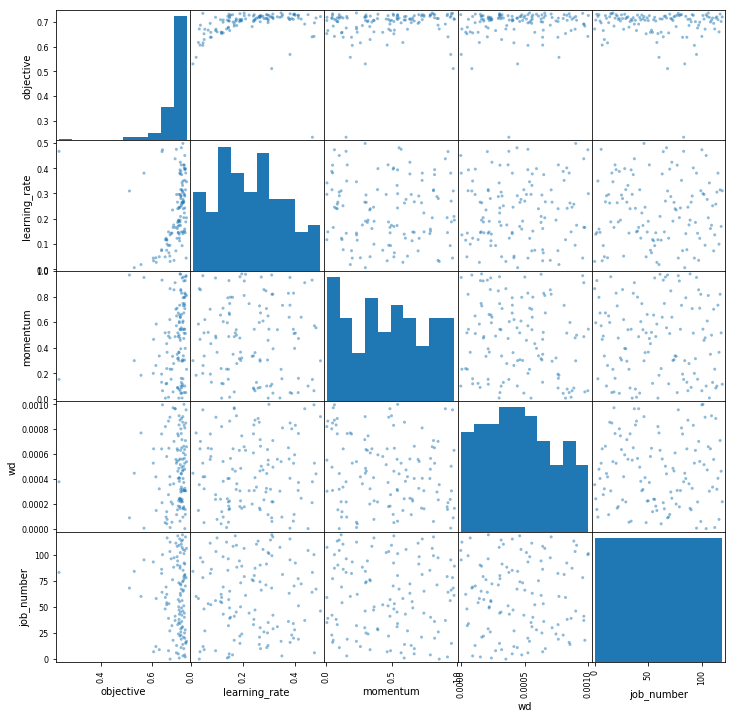

In [32]:
pd.plotting.scatter_matrix(random_metrics[['objective',
                                           'learning_rate',
                                           'momentum',
                                           'wd',
                                           'job_number']],
                           figsize=(12, 12))
plt.show()

---

## Host

Now that we've trained our model, deploying it to a real-time, production endpoint is easy.

In [50]:
predictor = m.deploy(initial_instance_count=1, 
                     instance_type='ml.m4.xlarge')
predictor.serializer = None

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2020-05-16-15-13-59-615
Creating model with name: sagemaker-mxnet-2020-05-16-15-13-59-615
DEBUG:sagemaker:CreateModel request: {
    "ModelName": "sagemaker-mxnet-2020-05-16-15-13-59-615",
    "ExecutionRoleArn": "arn:aws:iam::618779922646:role/AmazonSageMakerFullAccess",
    "PrimaryContainer": {
        "Image": "520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-mxnet:1.1-cpu-py3",
        "Environment": {
            "SAGEMAKER_PROGRAM": "recommender.py",
            "SAGEMAKER_SUBMIT_DIRECTORY": "s3://dse-cohort5-group1/sagemaker-mxnet-2020-05-16-15-13-59-615/source/sourcedir.tar.gz",
            "SAGEMAKER_ENABLE_CLOUDWATCH_METRICS": "false",
            "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
            "SAGEMAKER_REGION": "us-east-1"
        },
        "ModelDataUrl": "s3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/output/sagemaker-mxnet-2020-05-16-15-13-59-615/output/model.tar.gz"
    }
}
CreateModel

---------------!time: 7min 32s


Now that we have an endpoint, let's test it out.  We'll predict user #6's ratings for the top and bottom ASINs from our local model.

*This could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK.*

In [51]:
predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(), 
                              'product_id': ['B00HSJRT7I', 'B001FA1O1S']}))

[4.414754867553711, 4.414754867553711]

time: 223 ms


*Note, some of our predictions are actually greater than 5, which is to be expected as we didn't do anything special to account for ratings being capped at that value.  Since we are only looking to ranking by predicted rating, this won't create problems for our specific use case.*

In [52]:
json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(), 'product_id': ['B00HSJRT7I', 'B001FA1O1S']})

'{"customer_id": [52955495], "product_id": ["B00HSJRT7I", "B001FA1O1S"]}'

time: 4.3 ms


In [53]:
reduced_df.sample(n=2)

,customer_id,product_id,star_rating,product_title,user,item
110490,1831280,B0010WOV7A,5,Nike Air Ring Leader Low Mens Basketball Shoes...,14844,16599
13923,46823000,B000PDEUM6,5,Baggallini Messenger Travel Bag,4002,1227


time: 27.9 ms


### Evaluate

Let's start by calculating a naive baseline to approximate how well our model is doing.  The simplest estimate would be to assume every user item rating is just the average rating over all ratings.

*Note, we could do better by using each individual video's average, however, in this case it doesn't really matter as the same conclusions would hold.*

In [54]:
print('Naive MSE:', np.mean((test_df['star_rating'] - np.mean(train_df['star_rating'])) ** 2))

Naive MSE: 1.1623484128292114
time: 3.71 ms


Now, we'll calculate predictions for our test dataset.

*Note, this will align closely to our CloudWatch output above, but may differ slightly due to skipping partial mini-batches in our eval_net function.*

In [55]:
test_preds = []
for array in np.array_split(test_df[['customer_id', 'product_id']].values, 40):
    test_preds += predictor.predict(json.dumps({'customer_id': array[:, 0].tolist(), 
                                                'product_id': array[:, 1].tolist()}))

test_preds = np.array(test_preds)
print('MSE:', np.mean((test_df['star_rating'] - test_preds) ** 2))

MSE: 1.2664266281692826
time: 4.49 s


We can see that our neural network and embedding model produces substantially better results (~1.27 vs 1.65 on mean square error).

For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.

In [56]:
reduced_df[reduced_df['user'] == 6].sort_values(['star_rating', 'item'], ascending=[False, True])

,customer_id,product_id,star_rating,product_title,user,item
3407,52955495,B0013KFKBK,5,eBags Piazza Day Bag,6,302
3470,52955495,B00E9CCQ9S,5,Skechers Performance Women's Go Walk 2-Spark W...,6,2889
3440,52955495,B009ZDFKCQ,5,Skechers Performance Women's Go Walk 2 Slip-On...,6,3463
3397,52955495,B00ARR4XNG,5,Clarks Women's Kessa Mabel Ankle Boot,6,4240
3403,52955495,B00742Q9CK,5,Skechers Performance Women's Go Walk Autumn Sl...,6,8856
3436,52955495,B00HSHJ5KO,5,Skechers Performance Women's Go Walk 2 Hypo Wa...,6,11240
3477,52955495,B00HZ1402Q,5,Clarks Women's Christine Tilt Boot,6,28970
3427,52955495,B00I67TL6I,4,Skechers Performance Women's Go Walk Impress M...,6,1740
3449,52955495,B00E4FJDXC,4,Clarks Women's Haley Toucan Flat,6,5300
3457,52955495,B00D6EHCRQ,4,Baggallini Criss Cross Bagg,6,5317


time: 14 ms


In [57]:
reduced_df.to_csv("./amazon_reviews_us_Shoes_v1_00.csv")

time: 1.09 s


As we can see, user #6 seems to like sprawling dramamtic television series and sci-fi, but they dislike silly comedies.

Now we'll loop through and predict user #6's ratings for every common video in the catalog, to see which ones we'd recommend and which ones we wouldn't.

In [58]:
predictions = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist() * array.shape[0], 
                                                 'product_id': array.tolist()}))

predictions = pd.DataFrame({'product_id': product_index['product_id'],
                            'prediction': predictions})

time: 3.47 s


In [59]:
titles = reduced_df.groupby('product_id')['product_title'].last().reset_index()
predictions_titles = predictions.merge(titles)
predictions_titles.sort_values(['prediction', 'product_id'], ascending=[False, True])

,product_id,prediction,product_title
33713,B00HSICLV8,5.259201,Skechers Performance Women's Go Walk 2 Super S...
11298,B000XEQDT0,5.196434,Timberland PRO Men's Direct Attach Six-Inch So...
33603,B00J3YF7Q6,5.157457,Ray-Ban ROUND METAL - MATTE GOLD Frame GREEN M...
22558,B002AMW0Q8,5.156773,ECCO Men's Helsinki Cap-Toe Oxford Dress Shoe
7065,B00099E7BU,5.060513,adidas Samba Classic Leather Soccer Shoe (Todd...
31090,B00FLCWA96,5.059525,Kung Fu Shoes -Cotton Sole
38875,B000RSLKW2,5.048052,Sperry Top-Sider Angelfish Jacquard
20355,B007W2GBNE,5.047851,ASICS Men's GEL-Kayano 19 Running Shoe
34389,B00ESH57OU,5.027203,FitFlop Women's Flora Flip-Flop
8174,B003LXTZH2,5.024946,Shoelaces in 30 Colors to choose from! Flat wi...


time: 318 ms


Indeed, our predicted highly rated shows have some well-reviewed TV dramas and some sci-fi.  Meanwhile, our bottom rated shows include goofball comedies.

*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

In [61]:
reduced_df.to_csv("./user_6_amazon_reviews_us_Shoes_v1_00.csv")

time: 1.06 s


DEBUG:matplotlib.axes._base:update_title_pos
update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
update_title_pos


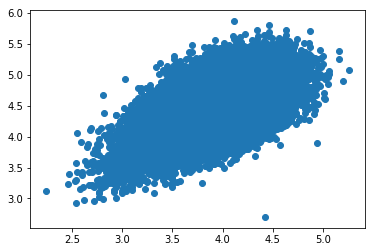

time: 3.98 s


In [60]:
predictions_user7 = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions_user7 += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 7]['customer_id'].values.tolist() * array.shape[0], 
                                                       'product_id': array.tolist()}))
plt.scatter(predictions['prediction'], np.array(predictions_user7))
plt.show()

---

## Wrap-up

In this example, we developed a deep learning model to predict customer ratings.  This could serve as the foundation of a recommender system in a variety of use cases.  However, there are many ways in which it could be improved.  For example we did very little with:
- hyperparameter tuning
- controlling for overfitting (early stopping, dropout, etc.)
- testing whether binarizing our target variable would improve results
- including other information sources (video genres, historical ratings, time of review)
- adjusting our threshold for user and item inclusion 

In addition to improving the model, we could improve the engineering by:
- Setting the context and key value store up for distributed training
- Fine tuning our data ingestion (e.g. num_workers on our data iterators) to ensure we're fully utilizing our GPU
- Thinking about how pre-processing would need to change as datasets scale beyond a single machine

Beyond that, recommenders are a very active area of research and techniques from active learning, reinforcement learning, segmentation, ensembling, and more should be investigated to deliver well-rounded recommendations.

### Clean-up (optional)

Let's finish by deleting our endpoint to avoid stray hosting charges.

In [49]:
# sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-2020-05-16-15-13-59-615
Deleting endpoint with name: sagemaker-mxnet-2020-05-16-15-13-59-615


time: 130 ms


## Reference APID

- MXNet Estimator
    - https://sagemaker.readthedocs.io/en/stable/sagemaker.mxnet.html#mxnet-estimator
    